# Predicting Gentrification
*A study into planning application features that can help to signal early warnings of gentrification*
</br></br></br></br>
`Notebook 4: Classification Models`</br>
Author: Mariia Shapovalova</br>
Date: April, 2023

---
## Table of Contents
Notebook 4: Modelling
- [0.0 Initial Models](#identifier_0)
  - A - Model Containing all features
  - B - Model with features that did not pass ttest in notebook 3 removed
  - C - Model with multicollinear features removed
  - Gridseach for model A and C
  - Residuals viewed on the map
- [1.0 NLP Model](#identifier_1)
  - Initial NlP Model
  - Gridsearch
- [2.0 Stacked Model](#identifier_2)
  - Optimizing the length of training and prediction windows
  - Gridsearch


---
<center><h2 id="identifier_0">NOTEBOOK INTRODUCTION</h2><center>

* This notebook focuses on developing classification models based on previously defined metrics. 
* In this notebook, we will create three different model typologies:
  * First typology: having one distinct census tract in the dataframe and predicting from a fixed year
    * For this typology, three different set of features will be tested (all features, features that passed the statistical test and features after multicollinearity cleaning)
  * Second typology: an NLP model to analyze the text descriptions of applications, attempting to define words that would indicate gentrification
    * for this typology, only income and application descriptions will be used
  * Third typology: 
    * instead of using a fixed year for prediction, looping through all possible year combinations given the input train and prediction window
    * then stacking all the groups together to result in a larger dataset

***

In [36]:
import pandas as pd
import numpy as np

#visualisations
import matplotlib.pyplot as plt
import seaborn as sns

import re
import random
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import OneHotEncoder

# To set up a temporary directory for caching pipeline results
from tempfile import mkdtemp
import tempfile

# To build a pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# To build custom column column transformers
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# To do a cross-validated grid search
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [37]:
#import custom functions
from functions import *

## Load Data

In [38]:
df=pd.read_csv('../data/clean/merged_df',index_col=0)

In [39]:
overview (df)

The dataframe shape is (724869, 29)


,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
PERMIT_TYPE,object,0,0.0,RENOVATION/ALTERATION,ELECTRIC WIRING,ELECTRIC WIRING
REVIEW_TYPE,object,0,0.0,STANDARD PLAN REVIEW,EASY PERMIT WEB,EASY PERMIT WEB
WORK_DESCRIPTION,object,0,0.0,INTERIOR REMODELING OF EXISTING 3 D.U. PER PLA...,INSTALLATION OF (1) 30 AMP DUAL POLE BREAKER A...,REVISION TO PERMIT #100546970 TO CHANGE THE EL...
CONTACT_1_TYPE,object,0,0.0,OWNER AS GENERAL CONTRACTOR,CONTRACTOR-ELECTRICAL,EXPEDITOR
CONTACT_1_CITY,object,0,0.0,CHICAGO,CHICAGO,CHICAGO
CONTACT_1_STATE,object,0,0.0,IL,IL,IL
LOG_PROCESSING_TIME,float64,0,0.0,4.394449,1.791759,-23.025851
LOG_BUILDING_FEE_PAID,float64,0,0.0,4.828314,3.688879,3.912023
LOG_ZONING_FEE_PAID,float64,0,0.0,4.317488,-23.025851,-23.025851


***
<center><h2>Test/Remainder Split<center><h2>

In [43]:
df.query('Mean_Income_2021 == Mean_Income_2021.max()')

,PERMIT_TYPE,REVIEW_TYPE,WORK_DESCRIPTION,CONTACT_1_TYPE,CONTACT_1_CITY,CONTACT_1_STATE,LOG_PROCESSING_TIME,LOG_BUILDING_FEE_PAID,LOG_ZONING_FEE_PAID,LOG_OTHER_FEE_PAID,...,Mean_Income_2013,Mean_Income_2014,Mean_Income_2015,Mean_Income_2016,Mean_Income_2017,Mean_Income_2018,Mean_Income_2019,Mean_Income_2020,Mean_Income_2021,Household_Count
523748,EASY PERMIT PROCESS,EASY PERMIT,INSTALL (1) LAYER OF RUBBER ROLL-SEAL EDGES WI...,OWNER AS GENERAL CONTRACTOR,CHICAGO,IL,-23.025851,4.923624,4.317488,-23.025851,...,190800.0,185166.0,172638.0,168201.0,182847.0,224724.0,265489.0,303998.0,316864.0,1238.0
523749,ELECTRIC WIRING,ELECTRICAL PLAN REVIEW,Install low voltage burglar alarm check # 8647,CONTRACTOR-ELECTRICAL,CHICAGO_SUBURBS,TX,3.663562,3.688879,-23.025851,-23.025851,...,190800.0,185166.0,172638.0,168201.0,182847.0,224724.0,265489.0,303998.0,316864.0,1238.0
523750,DROP,STANDARD PLAN REVIEW,ALL WORK SUBJECT TO FIELD INSPECTION : REMOVE ...,CONTRACTOR-GENERAL CONTRACTOR,CHICAGO,IL,-23.025851,4.665795,4.317488,-23.025851,...,190800.0,185166.0,172638.0,168201.0,182847.0,224724.0,265489.0,303998.0,316864.0,1238.0
523751,EASY PERMIT PROCESS,EASY PERMIT,REPLACE PLUMBING FIXTURES ONLY,CONTRACTOR-PLUMBER/PLUMBING,CHICAGO_SUBURBS,OTHER,-23.025851,4.653960,-23.025851,-23.025851,...,190800.0,185166.0,172638.0,168201.0,182847.0,224724.0,265489.0,303998.0,316864.0,1238.0
523752,EASY PERMIT PROCESS,EASY PERMIT,REVISION TO PERMIT 100237152 ISSUED 6/ 26 / 08...,CONTRACTOR-GENERAL CONTRACTOR,CHICAGO,IL,-23.025851,3.912023,-23.025851,-23.025851,...,190800.0,185166.0,172638.0,168201.0,182847.0,224724.0,265489.0,303998.0,316864.0,1238.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524609,EASY PERMIT PROCESS,EASY PERMIT,CONCRETE REPAIRS. SLABJACKING & GROUTING.,MASONRY CONTRACTOR,OTHER,IL,-23.025851,5.521461,3.912023,-23.025851,...,190800.0,185166.0,172638.0,168201.0,182847.0,224724.0,265489.0,303998.0,316864.0,1238.0
524610,EASY PERMIT PROCESS,EASY PERMIT,WORK TO UNIT A: INSTALL (1) HELICAL SHAFT WITH...,EXPEDITOR,CHICAGO,IL,-23.025851,5.521461,3.912023,-23.025851,...,190800.0,185166.0,172638.0,168201.0,182847.0,224724.0,265489.0,303998.0,316864.0,1238.0
524611,RENOVATION/ALTERATION,STANDARD PLAN REVIEW,FOUNDATION REINFORCING FOR EXISTING TWO STORY ...,OWNER OCCUPIED,CHICAGO,IL,-23.025851,6.329721,3.912023,-23.025851,...,190800.0,185166.0,172638.0,168201.0,182847.0,224724.0,265489.0,303998.0,316864.0,1238.0
524612,RENOVATION/ALTERATION,STANDARD PLAN REVIEW,FOUNDATION UNDERPINNING OF AN EXISTING THREE (...,OWNER OCCUPIED,CHICAGO,IL,3.367296,6.214608,3.912023,-23.025851,...,190800.0,185166.0,172638.0,168201.0,182847.0,224724.0,265489.0,303998.0,316864.0,1238.0


In [40]:
m = re.search(r'(?<=-)\w+', 'spam-egg')
m.group(0)

'egg'

In [30]:
'1hey'.find('hey')

1

In [27]:
df_copy['WORK_DESCRIPTION'].apply(lambda x: re.sub(r'/', '', x))

0         INTERIOR REMODELING OF EXISTING 3 D.U. PER PLA...
1         REPLACE REAR OPEN WOOD PORCH WITH A NEW STEELW...
2         DECONVERT 2ND FLOOR APARTMENT TO MAKE BUILDING...
3                                 LOW VOLTAGE BURGLAR ALARM
4         REPAIR EXISTNG TWO STORY WOOD FRAME PORCH PER ...
                                ...                        
724864    adding gfi protection to existing receptacles ...
724865    PORCH REPAIR PERMIT ONLY (NO INTERIOR WORK UND...
724866    REPLACE APPRX. 100 SHEETS OF GYP. BRD. MAXIMUM...
724867    INSTALLATION OF (1) 30 AMP DUAL POLE BREAKER A...
724868    INSTALLATION OF (1) 30 AMP DUAL POLE BREAKER A...
Name: WORK_DESCRIPTION, Length: 724869, dtype: object

In [16]:
df_copy.apply(lambda x: x['WORK_DESCRIPTION'][0:10],axis=1)

0         INTERIOR R
1         REPLACE RE
2         DECONVERT 
3         LOW VOLTAG
4         REPAIR EXI
             ...    
724864    adding gfi
724865    PORCH REPA
724866    REPLACE AP
724867    INSTALLATI
724868    INSTALLATI
Length: 724869, dtype: object

In [17]:
df_copy['WORK_DESCRIPTION'].str[0:10]

0         INTERIOR R
1         REPLACE RE
2         DECONVERT 
3         LOW VOLTAG
4         REPAIR EXI
             ...    
724864    adding gfi
724865    PORCH REPA
724866    REPLACE AP
724867    INSTALLATI
724868    INSTALLATI
Name: WORK_DESCRIPTION, Length: 724869, dtype: object

In [14]:
df_copy['WORK_DESCRIPTION'].apply(lambda x: x[0:10])

0         INTERIOR R
1         REPLACE RE
2         DECONVERT 
3         LOW VOLTAG
4         REPAIR EXI
             ...    
724864    adding gfi
724865    PORCH REPA
724866    REPLACE AP
724867    INSTALLATI
724868    INSTALLATI
Name: WORK_DESCRIPTION, Length: 724869, dtype: object

In [6]:
df[['Mean_Income_2013','YEAR']].apply(lambda x: 1 if (x['Mean_Income_2013']>5000 and x['YEAR']<2018) else 0, axis=1)

0         1
1         1
2         1
3         1
4         1
         ..
724864    1
724865    1
724866    1
724867    1
724868    1
Length: 724869, dtype: int64

In [7]:
df[['Mean_Income_2013','YEAR']].apply(lambda x: 1 if (x['Mean_Income_2013']>5000 and x['YEAR']<2018) else 0, axis=1)

0         1
1         1
2         1
3         1
4         1
         ..
724864    1
724865    1
724866    1
724867    1
724868    1
Length: 724869, dtype: int64

In [9]:
df_copy=df.copy()

In [ ]:
df_copy.insert(new_col=lambda x: )

In [8]:
(lambda x: [1,0], (df['Mean_Income_2013']>5000 and df['YEAR']<2018, axis=1))

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (114238338.py, line 1)

* Test/Validation/Train Splits will be done based on the census tracts (geographies)
* Let's select 20% of the distinct census tracts and separate them in the test dataframe

In [6]:
import random

test_size=0.2

#create a set of distinct census tracts
geo_set=set(df['Census_Tract'])

#measure its length and multiply by the specified test si\e
test_len=int(len(geo_set)*test_size)

random.seed(42)
#select a random subset of distinct census tract of the required size
geo_test=random.sample(list(geo_set),k=test_len)

#create test mask by testing if census tracts belong to the test subset
test_mask=df['Census_Tract'].isin(geo_test)

#apply the mask to generate the test dataset and the inverse to generate remainder dataset
df_test=df[test_mask].reset_index(drop=True)
df_rem=df[~test_mask].reset_index(drop=True)

In [7]:
#check the shapes
print('remained df shape is ', df_rem.shape)
print('test df shape is ', df_test.shape)

remained df shape is  (546259, 29)
test df shape is  (178610, 29)


---
<center><h2 id="heading_identifier_1">INITIAL MODELS</h2>


**Preprocessing Steps**

* OHE:
  * Fit & transform on train
  * Transform only on test
  * All columns are numeric apart from Work Description
* Group by Census Tract & Year
  * Average Numeric Columns
  * Combine descriptions for Work Description Column
* Determine intial train and prediction windows
  * Baseline model: split at 2013
    * training on 2006 to 2013 data
    * predicting from 2013 to 2021
* Split X and y

---
* **OHE**

In [8]:
ohe_col=list(df_rem.drop(columns='WORK_DESCRIPTION').select_dtypes(include=['object']).columns)
ohe_col

['PERMIT_TYPE',
 'REVIEW_TYPE',
 'CONTACT_1_TYPE',
 'CONTACT_1_CITY',
 'CONTACT_1_STATE',
 'New_Topics']

* Custom Column Transformer: One Hot Encoding that returns a whole dataframe with column names and one hot encoded column dropped

In [9]:
from functions import CustomOneHotEncoder_CT

* `Function Transformer 2`: Grouping by Census Tract and Year
  * based on the year we are making the prediction from and the training length

In [10]:
from functions import df_window_multi_type

* `Custom Transformer 3`: Convert income data into a Binary Target Column calculating if gentrification occured
  * based on the year we are making the prediction from and the prediction length

In [11]:
from functions import comb_change_calc
#Import previously defined function to calculate the combined change metric between incomes from two years using the formula

In [12]:
class GentrificationTarget(BaseEstimator, TransformerMixin):
    def __init__(self,year,prediction_period,metric,perc_power):
        self.year=year
        self.prediction_period=prediction_period
        self.metric=metric
        if metric=='power':
            self.perc_power=perc_power
        self.current_income_col=None
        self.future_income_col=None
        self.median_change=None


    def fit(self,df,y=None):

        #name of the column containing income for the current year
        self.current_income_col='Mean_Income_'+str(self.year)

        #the year we are making the prediction for
        prediction_year=self.year+self.prediction_period

        #name of the column containing income for the year we are making the prediction for
        self.future_income_col='Mean_Income_'+str(prediction_year)

        current_income=df[self.current_income_col]
        future_income=df[self.future_income_col]

        if self.metric=='self':
            combined_change=[comb_change_calc(start,finish) for (start,finish) in zip(current_income,future_income)]
        
        elif self.metric=='power':
            combined_change=[comb_change_calc_power(start,finish,perc_power=self.perc_power) for (start,finish) in zip(current_income,future_income)]

        #fitting in our case is just finding the median change
        self.median_change=np.median(combined_change)
        #returning self with updated attributes that can be accessed in the transform method later
        return self

    def transform(self, df, y=None):
        #this method transforms the existing dataframe to calculate if the change for each geography was more or less than the mean 
        #dropping all the other columns

        df_temp=df.copy()

        current_income=df[self.current_income_col]
        future_income=df[self.future_income_col]

        if self.metric=='self':
            combined_change=[comb_change_calc(start,finish) for (start,finish) in zip(current_income,future_income)]
        
        elif self.metric=='power':
            combined_change=[comb_change_calc_power(start,finish,perc_power=self.perc_power) for (start,finish) in zip(current_income,future_income)]

        #this is y_target column as a list
        target=[1 if i>self.median_change else 0 for i in combined_change]

        y_col=[col for col in list(df_temp.columns) if bool(re.search('Mean',col))]
        df_temp=df_temp.drop(columns=y_col)
        df_temp['Income']=current_income
        df_temp['Target']=target

        return df_temp

* `Function Transformer 4`: Split X and y columns

In [13]:
def select_columns(df):
    X = df.drop(columns='Target')
    y = df['Target']
    return X, y

***
# Modelling Typology 1: 
* **Dataframe Structure**: One distinct census tract in the input dataframe 
* **Input Features**: Numeric and One Hot Encoded Columns

`this cell takes XXX minutes to run`

In [14]:
#Define pipeline parameters that will remain constant for the loop
year=2013
train_period=5

prediction_period=8
metric='power'

#Instantiate a dataframe to store results of the loop
df_result=pd.DataFrame({'perc_power':[],'train_acc':[],'test_acc':[],'income_coef':[]})

#Loop through perc_power
for i,perc_power in enumerate(range(0,15)):

    #Define a pipeline for X and y preprocessing based on the steps outlined above
    X_y_prep_baseline = Pipeline(
        [
        #one hot encoding
        ('ohe', CustomOneHotEncoder_CT()),
        #grouping based on the year we are making the prediction from and the training length
        ('group',FunctionTransformer(df_window_multi_type, kw_args={'year': year, 't': train_period})),
        #convert income change into y_target based on the year we are making the prediction from and the prediction length and drop the remaining of Income columns
        ('target',GentrificationTarget(year,prediction_period,metric,perc_power)),
        #split into X & y
        ('X_y_split',FunctionTransformer(select_columns))
        ])

    #Define a modelling pipeline
    model_pipeline = Pipeline([
        ('scaler', MinMaxScaler()),   # data normalization step
        ('model', LogisticRegression())   # linear regression model
    ])

    #Conduct preprocessing using the first pipeline
    X_y_prep_baseline.fit(df_rem)
    X_rem,y_rem=X_y_prep_baseline.transform(df_rem)
    X_test,y_test=X_y_prep_baseline.transform(df_test)

    #Initial models not integrating work_desc
    #Drop Work Description Column
    X_rem=X_rem.drop(columns='WORK_DESCRIPTION')
    X_test=X_test.drop(columns='WORK_DESCRIPTION')

    #Fit the modelling pipeline on X_rem and y_rem
    model_pipeline.fit(X_rem,y_rem)
    find_metric=model_pipeline

    #save train and test accuracies
    train_acc=find_metric.score(X_rem,y_rem)
    test_acc=find_metric.score(X_test,y_test)

    #
    df_result.loc[i,'perc_power']=perc_power
    df_result.loc[i,'train_acc']=train_acc
    df_result.loc[i,'test_acc']=test_acc

    df_output=pipe_to_df(X_rem,find_metric)
    inc_coef=float(df_output[df_output.feature=='Income'].loc[:,'coefficients'])
    df_result.loc[i,'income_coef']=inc_coef

KeyboardInterrupt: 

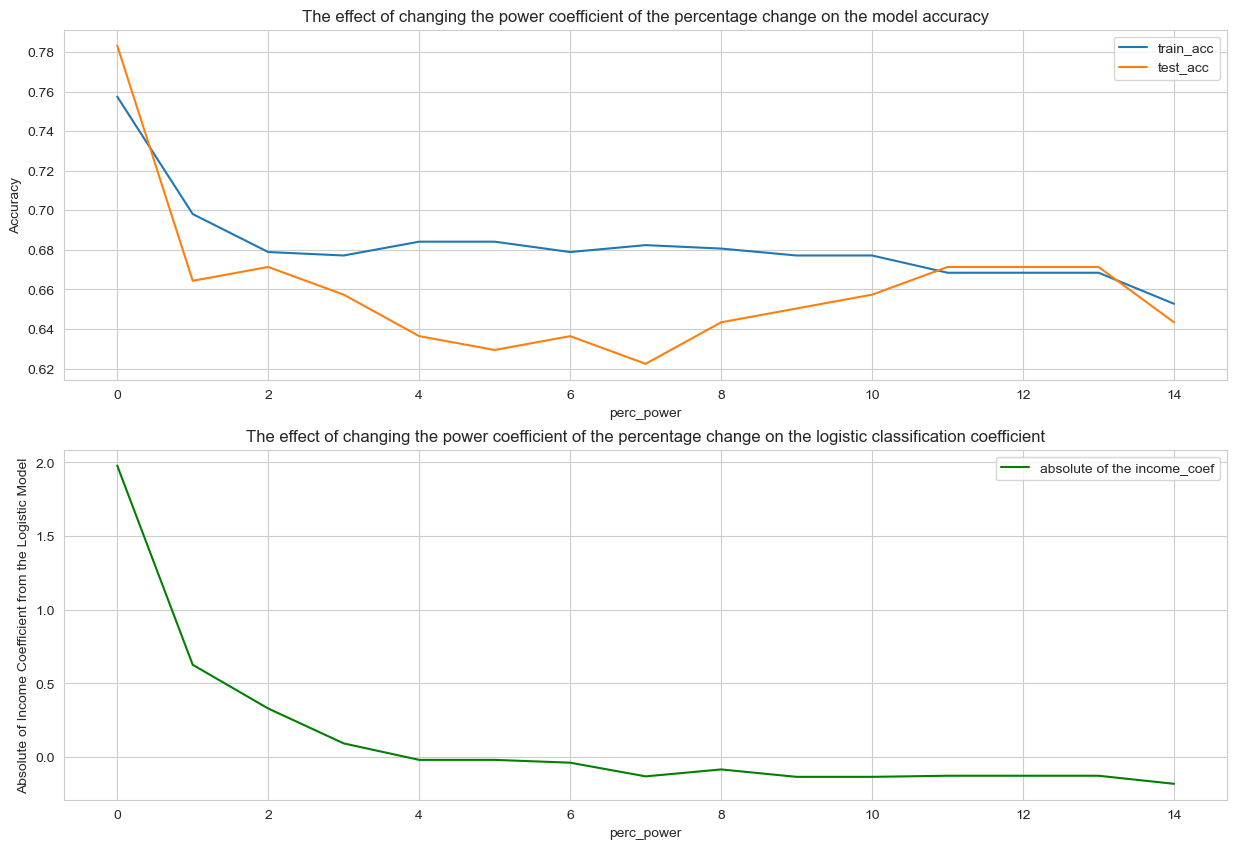

In [103]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(2,1, figsize=(15,10))

plt.subplot(2,1,1)

# Plot the chart
sns.lineplot(data=df_result, x='perc_power', y='train_acc',label='train_acc')
sns.lineplot(data=df_result, x='perc_power', y='test_acc',label='test_acc')
plt.ylabel('Accuracy')
#sns.lineplot(data=df_result, x='perc_power', y=abs(df_result.income_coef),label='income_coef')

plt.title('The effect of changing the power coefficient of the percentage change on the model accuracy')
plt.legend()

plt.subplot(2,1,2)

# Plot the chart
sns.lineplot(data=df_result, x='perc_power', y=df_result.income_coef,label='absolute of the income_coef',color='green')

plt.title('The effect of changing the power coefficient of the percentage change on the logistic classification coefficient')
plt.ylabel('Absolute of Income Coefficient from the Logistic Model')

plt.legend()

plt.show()


* Need to aim for the lowest absolute value of the income optimal perc_power
  * Optimal perc_power=2

In [94]:
df_result.iloc[df_result['income_coef'].idxmin()]['perc_power']

14.0

In [105]:
new_li=[]
for prediction_period in range (3,11):
    #Define pipeline parameters that will remain constant for the loop

    year=2010
    train_period=5
    metric='power'

    #Instantiate a dataframe to store results of the loop
    df_result=pd.DataFrame({'perc_power':[],'train_acc':[],'test_acc':[],'income_coef':[]})

    #Loop through perc_power
    for i,perc_power in enumerate(range(0,15)):

        #Define a pipeline for X and y preprocessing based on the steps outlined above
        X_y_prep_baseline = Pipeline(
            [
            #one hot encoding
            ('ohe', CustomOneHotEncoder_CT()),
            #grouping based on the year we are making the prediction from and the training length
            ('group',FunctionTransformer(df_window_multi_type, kw_args={'year': year, 't': train_period})),
            #convert income change into y_target based on the year we are making the prediction from and the prediction length and drop the remaining of Income columns
            ('target',GentrificationTarget(year,prediction_period,metric,perc_power)),
            #split into X & y
            ('X_y_split',FunctionTransformer(select_columns))
            ])

        #Define a modelling pipeline
        model_pipeline = Pipeline([
            ('scaler', MinMaxScaler()),   # data normalization step
            ('model', LogisticRegression())   # linear regression model
        ])

        #Conduct preprocessing using the first pipeline
        X_y_prep_baseline.fit(df_rem)
        X_rem,y_rem=X_y_prep_baseline.transform(df_rem)
        X_test,y_test=X_y_prep_baseline.transform(df_test)

        #Initial models not integrating work_desc
        #Drop Work Description Column
        X_rem=X_rem.drop(columns='WORK_DESCRIPTION')
        X_test=X_test.drop(columns='WORK_DESCRIPTION')

        #Fit the modelling pipeline on X_rem and y_rem
        model_pipeline.fit(X_rem,y_rem)
        find_metric=model_pipeline

        #save train and test accuracies
        train_acc=find_metric.score(X_rem,y_rem)
        test_acc=find_metric.score(X_test,y_test)

        #
        df_result.loc[i,'perc_power']=perc_power
        df_result.loc[i,'train_acc']=train_acc
        df_result.loc[i,'test_acc']=test_acc

        df_output=pipe_to_df(X_rem,find_metric)
        inc_coef=float(df_output[df_output.feature=='Income'].loc[:,'coefficients'])
        df_result.loc[i,'abs_income_coef']=abs(inc_coef)


    x=df_result.iloc[df_result['abs_income_coef'].idxmin()]['perc_power']
    k=(prediction_period,x,df_result.abs_income_coef)
    new_li.append(k)
    print(k)

(3, 10.0, 0     2.721647
1     0.856219
2     1.282291
3     0.845722
4     1.009469
5     0.903658
6     0.756641
7     0.898601
8     0.696186
9     0.898601
10    0.635852
11    0.898601
12    0.635852
13    0.898601
14    0.635852
Name: abs_income_coef, dtype: float64)
(4, 2.0, 0     2.052301
1     1.360260
2     0.399465
3     1.493910
4     0.656636
5     1.493910
6     0.709766
7     1.545526
8     0.709766
9     1.545526
10    0.899366
11    1.545526
12    0.894392
13    1.545526
14    0.952458
Name: abs_income_coef, dtype: float64)
(5, 4.0, 0     2.023879
1     1.017640
2     0.336452
3     1.395868
4     0.137005
5     1.438422
6     0.326709
7     1.546260
8     0.427734
9     1.546260
10    0.474088
11    1.546260
12    0.474088
13    1.515777
14    0.474088
Name: abs_income_coef, dtype: float64)
(6, 4.0, 0     2.684579
1     0.817204
2     0.332247
3     1.053818
4     0.164841
5     1.041198
6     0.446309
7     1.204086
8     0.515247
9     1.204086
10    0.515247
11    

**Model A**
* First, let's fit a model with all the one hot encoded features, without conducting any further feature selection
* `model A contains all the features without conducting any statistical tests`

In [70]:
year=2010
train_period=3
prediction_period=11
metric='power'
perc_power=7

#Define a pipeline for X and y preprocessing based on the steps outlined above
X_y_prep_baseline = Pipeline(
    [
    #one hot encoding
    ('ohe', CustomOneHotEncoder_CT()),
    #grouping based on the year we are making the prediction from and the training length
    ('group',FunctionTransformer(df_window_multi_type, kw_args={'year': year, 't': train_period})),
    #convert income change into y_target based on the year we are making the prediction from and the prediction length and drop the remaining of Income columns
    ('target',GentrificationTarget(year,prediction_period,metric,perc_power)),
    #split into X & y
    ('X_y_split',FunctionTransformer(select_columns))
    ])

#Define a modelling pipeline
model_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),   # data normalization step
    ('model', LogisticRegression())   # linear regression model
])

In [71]:
#Conduct preprocessing using the first pipeline
X_y_prep_baseline.fit(df_rem)
X_rem,y_rem=X_y_prep_baseline.transform(df_rem)
X_test,y_test=X_y_prep_baseline.transform(df_test)

#Initial models not integrating work_desc
#Drop Work Description Column
X_rem=X_rem.drop(columns='WORK_DESCRIPTION')
X_test=X_test.drop(columns='WORK_DESCRIPTION')

#Fit the modelling pipeline on X_rem and y_rem
model_pipeline.fit(X_rem,y_rem)
all_features_model=model_pipeline

* Print accuracy for the baseline model with all the features

In [72]:
train_accuracy = all_features_model.score(X_rem, y_rem)
test_accuracy = all_features_model.score(X_test, y_test)

print(f'Baseline model train accuracy is {train_accuracy*100:.2f}%')
print(f'Baseline model test accuracy is {test_accuracy*100:.2f}%')

Baseline model train accuracy is 67.31%
Baseline model test accuracy is 63.57%


In [73]:
df_output=pipe_to_df(X_rem,all_features_model)
df_output.sort_values('coefficients')[:15]

,feature,coefficients
42,CONTACT_1_TYPE_OWNER AS ARCHITECT & CONTRACTR,-0.846302
18,REVIEW_TYPE_EASY PERMIT,-0.809501
52,CONTACT_1_CITY_CHICAGO_SUBURBS,-0.807327
34,CONTACT_1_TYPE_CONTRACTOR-VENTILATION,-0.782515
21,REVIEW_TYPE_FIRE PROTECTION SYSTEM,-0.764169
61,CONTACT_1_STATE_TX,-0.748036
70,New_Topics_repair,-0.665267
57,CONTACT_1_CITY_OTHER,-0.657832
10,PERMIT_TYPE_ELECTRIC WIRING,-0.653119
14,PERMIT_TYPE_SCAFFOLDING,-0.544073


In [74]:
df_output=pipe_to_df(X_rem,all_features_model)
df_output.sort_values('coefficients')[-15:]

,feature,coefficients
9,PERMIT_TYPE_EASY PERMIT PROCESS,0.524746
58,CONTACT_1_STATE_IL,0.538828
53,CONTACT_1_CITY_ELK GROVE VILLAGE,0.541673
19,REVIEW_TYPE_EASY PERMIT WEB,0.586019
71,New_Topics_wrecking,0.613972
25,REVIEW_TYPE_TRADITIONAL DEVELOPER SERVICES,0.627959
37,CONTACT_1_TYPE_EXPEDITOR,0.654315
39,CONTACT_1_TYPE_MASONRY CONTRACTOR,0.712340
22,REVIEW_TYPE_SELF CERT,0.719004
50,CONTACT_1_TYPE_UNKNOWN,0.731630


* Initial accuracy scores might appear relatively high, but it should be noted that test scores are surprisingly slighly higher than the train scores
* Additioanlly, should be noted that the class distribution is aroudn 50/50, which means that guessing gentrified every time would give a baseline accuracy of 50 %
* This could happen because the model is underfitting or because the pattern capturing the link between income change and building permits happened to be in the test test due to the small size of the dataset
* A grid search will be run later on in the notebook to further evaluate the model performance

In [75]:
#Define a function to generate confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def conf_matrix(model,X_test):
    y_pred = model.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)

    cf_df = pd.DataFrame(
        cf_matrix, 
        columns=["Predicted No-Gentrification", "Predicted Gentrification"],
        index=["True No-Gentrification", "True Gentrification"]
    )

    display(cf_df)

    tp = cf_matrix[1, 1]
    predicted_gentrification = cf_matrix[:, 1].sum()
    precision = tp/predicted_gentrification
    print(f"Precision = {tp}/{predicted_gentrification} = {round(precision*100, 2)}%")

    true_gentrification = cf_matrix[1, :].sum()
    recall = tp/true_gentrification
    print(f"Recall = {tp}/{true_gentrification} = {round(recall*100, 2)}%")

    # the function expects the estimator, inputs and target as parameters
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

`Confusion Matrix for Model A`

,Predicted No-Gentrification,Predicted Gentrification
True No-Gentrification,35,20
True Gentrification,31,54


Precision = 54/74 = 72.97%
Recall = 54/85 = 63.53%


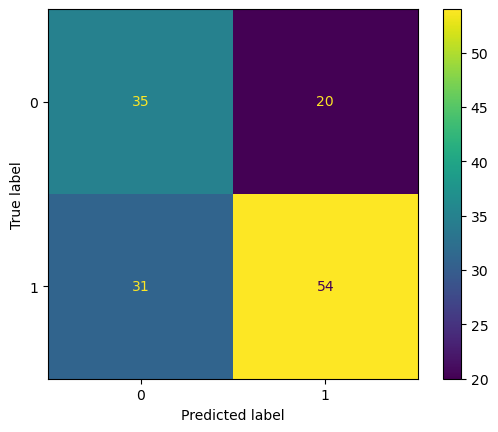

In [76]:
conf_matrix(all_features_model,X_test)

* Out of 75 gentrified geographies, model a picked up on 46, resulting in a recall score of 61%
* Out of 63 labelled as gentrified, 46 were labelled correcly, leading to the precision score of 73%

---
To form next modelling feature sets import outcome of statistic test and multicollinearity explorations

In [77]:
#load the columns to be dropped based on not passing the statistical t-test
columns_to_drop=joblib.load('../data/interim/MODEL_drop_feature_ttest.pkl')

#load dictionary to merge some of the categories together'
merging_categories_di=joblib.load('../data/interim/MODEL_change_cat.pkl')

#multocollinearity
multicol=joblib.load('../data/interim/MODEL_milticol.pkl')

**Model B**</br>
`Drop columns that did not pass t-test in notebook 3`

In [78]:
#apply the dictionary from notebook 3 to clean up some of the categories
df_rem_temp=df_rem.replace(merging_categories_di)
df_test_temp=df_test.replace(merging_categories_di)

#using the same pipeline preprocess data for modelling
X_y_prep_baseline.fit(df_rem_temp)
X_rem,y_rem=X_y_prep_baseline.transform(df_rem_temp)
X_test,y_test=X_y_prep_baseline.transform(df_test_temp)

X_rem=X_rem.drop(columns='WORK_DESCRIPTION')
X_test=X_test.drop(columns='WORK_DESCRIPTION')

#drop columns that did not pass t-test from the list `columns_to_drop` impored in the cell above
X_rem_ttest=X_rem.drop(columns=columns_to_drop)
X_test_ttest=X_test.drop(columns=columns_to_drop)

#fit a logistic model using the same modelling pipeline
model_pipeline.fit(X_rem_ttest,y_rem)
ttest_model=model_pipeline

In [79]:
train_accuracy = ttest_model.score(X_rem_ttest, y_rem)
test_accuracy = ttest_model.score(X_test_ttest, y_test)

print(f'Baseline model train accuracy is {train_accuracy*100:.2f}%')
print(f'Baseline model test accuracy is {test_accuracy*100:.2f}%')

Baseline model train accuracy is 64.16%
Baseline model test accuracy is 60.71%


,Predicted No-Gentrification,Predicted Gentrification
True No-Gentrification,33,22
True Gentrification,33,52


Precision = 52/74 = 70.27%
Recall = 52/85 = 61.18%


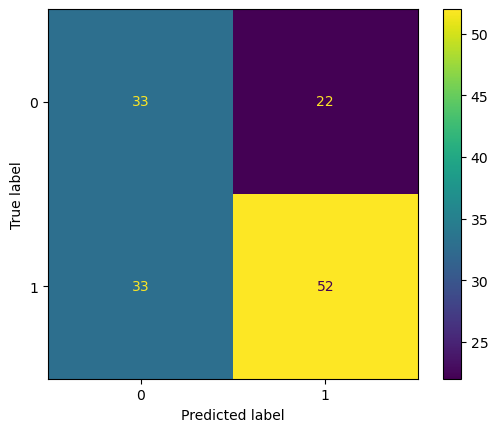

In [80]:
conf_matrix(ttest_model,X_test_ttest)

* After dropping features that proved to be not statistically significant using a t-test, accuracy reduced
* However, now we observe a more expected patter of train set having higher accuracy scores than the test set
* Recall score dropped to less than 50%

**Model C**</br>
`Drop multicollinear columns defined in notebook 3

In [81]:
#further drop columns that were multicollinear
X_rem_ttest_multicol=X_rem_ttest.drop(columns=multicol)
X_test_ttest_multicol=X_test_ttest.drop(columns=multicol)

model_pipeline.fit(X_rem_ttest_multicol,y_rem)
ttest_multicol_model=model_pipeline

In [82]:
train_accuracy = ttest_multicol_model.score(X_rem_ttest_multicol, y_rem)
test_accuracy = ttest_multicol_model.score(X_test_ttest_multicol, y_test)

print(f'Baseline model train accuracy is {train_accuracy*100:.2f}%')
print(f'Baseline model test accuracy is {test_accuracy*100:.2f}%')

Baseline model train accuracy is 64.34%
Baseline model test accuracy is 62.86%


* Dropping multicollinear columns appears to have marginally improved accuracy scores

,Predicted No-Gentrification,Predicted Gentrification
True No-Gentrification,32,23
True Gentrification,29,56


Precision = 56/79 = 70.89%
Recall = 56/85 = 65.88%


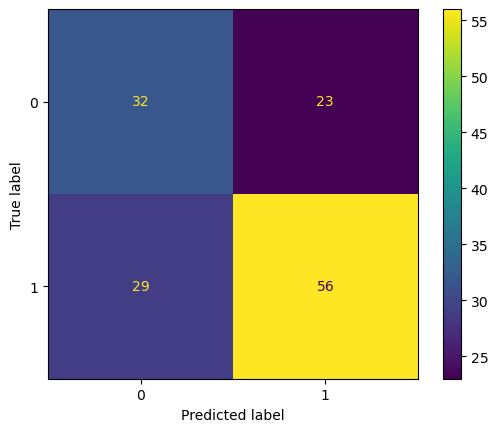

In [83]:
conf_matrix(ttest_multicol_model,X_test_ttest_multicol)

* Similarly, after dropping multicollinear columns, recall score has increased above 50%

* While model A resulted in the highest scores of 65%, using model A to evaluate coefficients might give mislleading results since it contains many multicollinear features
* Hence, let's use model C, which had multicollinear features removed, to preview model coefficients

In [84]:
logistic_model = ttest_multicol_model.named_steps['model']
coefficients = logistic_model.coef_[0]

In [85]:
results=pd.DataFrame({'features':X_rem_ttest_multicol.columns, 'coef':coefficients})
results.sort_values('coef',ascending=False)

,features,coef
12,CONTACT_1_CITY_CHICAGO,0.793885
18,Income,0.616709
17,New_Topics_wrecking,0.586502
11,CONTACT_1_TYPE_MASONRY CONTRACTOR,0.516899
10,CONTACT_1_TYPE_EXPEDITOR,0.356662
4,PERMIT_TYPE_NEW CONSTRUCTION,0.338352
15,New_Topics_alarm,0.291242
7,CONTACT_1_TYPE_ARCHITECT,0.185126
2,PERMIT_TYPE_EASY PERMIT PROCESS,0.169669
5,PERMIT_TYPE_RENOVATION/ALTERATION,0.165971


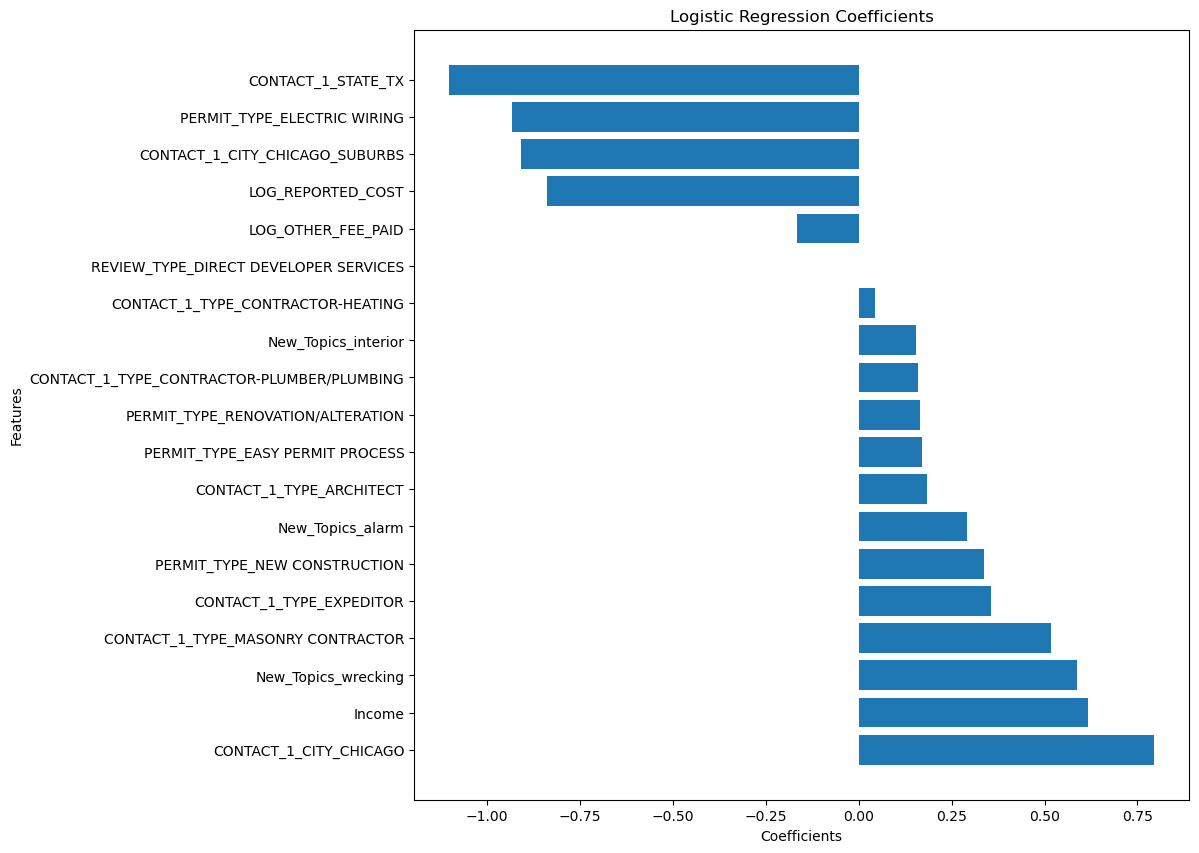

In [86]:
# sort the dataframe by coefficients
results_sorted = results.sort_values('coef', ascending=False)

# create a horizontal bar plot
fig=plt.subplots(figsize = (10, 10))

plt.barh(results_sorted['features'], results_sorted['coef'])

# set the title and labels
plt.title('Logistic Regression Coefficients')
plt.xlabel('Coefficients')
plt.ylabel('Features')

# show the plot
plt.show()


**Positive Indicators**
* New Construction Permit Types are an expected indicator of gentrification
* Masonry Contractor as the primary project contact is a more surprising indicator of gentrification
  * this might suggest higher-quality or more expensive construction
* Architect being responsible for a project result in a slightly increased likelihood of gentrification
</br></br>

**Negative Indicators**
* Primary Contact responsible for the project being a plumbing contractor or a heating contractor makes a district less likely to gentrify in the near future
  * implies that the project may be related to maintenance or repair work, which is less likely to indicate gentrification
* Interestingly, the model indicates that higher numbers of renovations point towards unlikely gentrification
  * This appears counter-intuitive and suggests that the model might be finding other patterns shared between the census tracts apart from gentrification
  * Nevertheless, it should be recalled that when conducting topic modelling on the Renovation Descriptions, a lot of them referred to maintenance work
* 'Income' at the year of the prediction also appears to be a negative indicator of gentrification. This signifies that the metric developed for classifying census tracts into gentrified and not gentrified is skewed towards lower-income areas

***

* Let's go back to model A and preview model residuals

In [29]:
year=2013
train_period=5
prediction_period=8
metric='power'
perc_power=4

X_y_prep_baseline = Pipeline(
    [
    #one hot encoding
    ('ohe', CustomOneHotEncoder_CT()),
    #grouping based on the year we are making the prediction from and the training length
    ('group',FunctionTransformer(df_window_multi_type, kw_args={'year': year, 't': train_period})),
    #convert income change into y_target based on the year we are making the prediction from and the prediction length and drop the remaining of Income columns
    ('target',GentrificationTarget(year,prediction_period,metric,perc_power)),
    #split into X & y
    ('X_y_split',FunctionTransformer(select_columns))
    ])

model_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),   # data normalization step
    ('regressor', LogisticRegression())   # linear regression model
])

X_y_prep_baseline.fit(df_rem)
X_rem,y_rem=X_y_prep_baseline.transform(df_rem)
X_test,y_test=X_y_prep_baseline.transform(df_test)

#Initial models not integrating work_desc
X_rem=X_rem.drop(columns='WORK_DESCRIPTION')
X_test=X_test.drop(columns='WORK_DESCRIPTION')

model_pipeline.fit(X_rem,y_rem)
all_features_model=model_pipeline

train_accuracy = all_features_model.score(X_rem, y_rem)
test_accuracy = all_features_model.score(X_test, y_test)

print(f'Baseline model train accuracy is {train_accuracy*100:.2f}%')
print(f'Baseline model test accuracy is {test_accuracy*100:.2f}%')

Baseline model train accuracy is 68.41%
Baseline model test accuracy is 63.64%


* Model Residuals

In [30]:
y_pred=all_features_model.predict(X_test)

residuals_df=pd.DataFrame()

#tp if y_pred is 1 and y_test is 1
#fp if y_pred is 0 but y_test is 1
#tn if y_pred is 0 and y_test is 0
#fn if y_pred is 1 but y_test is 0

for i in range(len(y_test)):
    if list(y_test)[i] == 1 and y_pred[i] == 1:
        # True positive
        residuals_df.loc[i, 'outcome'] = 'true_positive'
    elif list(y_test)[i] == 0 and y_pred[i] == 1:
        # False positive
        residuals_df.loc[i, 'outcome'] = 'false_positive'
    elif list(y_test)[i] == 0 and y_pred[i] == 0:
        # True negative
        residuals_df.loc[i, 'outcome'] = 'true_negative'
    elif list(y_test)[i] == 1 and y_pred[i] == 0:
        # False negative
        residuals_df.loc[i, 'outcome'] = 'false_negative'

residuals_df=residuals_df.fillna(0)

#add census tracts
residuals_df['Census_Tract']=y_test.index

In [31]:
#Load a dataframe with all the census tracts and their respective coordiantes from the current Permit Dataframe
ct_coord=joblib.load('../data/interim/ct_coord.pkl').reset_index(drop=True)
ct_coord=ct_coord.groupby('CENSUS_TRACT').mean().reset_index()

#add coordinates
residuals_coord_df=coord(residuals_df,ct_coord)

#add 2021 income
income_2021=df.groupby('Census_Tract')['Mean_Income_2021'].mean().reset_index()

residuals_coord_df=residuals_coord_df.merge(income_2021, on='Census_Tract')

* Preview correctly and incorrectly classfied geographies on a map to check for geographic or income biases

In [32]:
import plotly.express as px

outcome=residuals_coord_df['outcome']

fig = px.scatter_mapbox(residuals_coord_df, lat="LATITUDE", lon="LONGITUDE", color='outcome', color_discrete_map={'true_negative': 'green', 'false_positive': 'blue', 'false_negative': 'red', 'true_positive':'orange'}, size='Mean_Income_2021',zoom=10, mapbox_style="carto-positron")

fig.update_layout(width=1500,height=1000)

fig.show()

![Alt text](images/Plotly_2.png)

* The map displays model A predictions, with each shown in a different color. Note that the size of each marker is determined by the median income.
* There appears to be no strong geographic bias in the model's predictions, even though predictions of gentrification appear to be more clustered around the central area than predictions of no gentrification.
* This is surprising, given that model coefficients demonstrated that income had a negative coefficient. Hence, another feature must be inducing the geographic bias.

---
* Run this model with PCA to determine if 1 PC would be form a good model


In [32]:
model_pipeline_pca = Pipeline([
    ('scaler', MinMaxScaler()),
    ('dim_reducer', PCA(n_components=1)),
    ('regressor', LogisticRegression())   # linear regression model
])

model_pipeline_pca.fit(X_rem,y_rem)
all_features_model=model_pipeline_pca

train_accuracy = all_features_model.score(X_rem, y_rem)
test_accuracy = all_features_model.score(X_test, y_test)

print(f'Baseline model train accuracy is {train_accuracy*100:.2f}%')
print(f'Baseline model test accuracy is {test_accuracy*100:.2f}%')

Baseline model train accuracy is 56.41%
Baseline model test accuracy is 53.52%


* Using 1 PC results in very low acucracy scores

,Predicted No-Gentrification,Predicted Gentrification
True No-Gentrification,34,33
True Gentrification,33,42


Precision = 42/75 = 56.0%
Recall = 42/75 = 56.0%


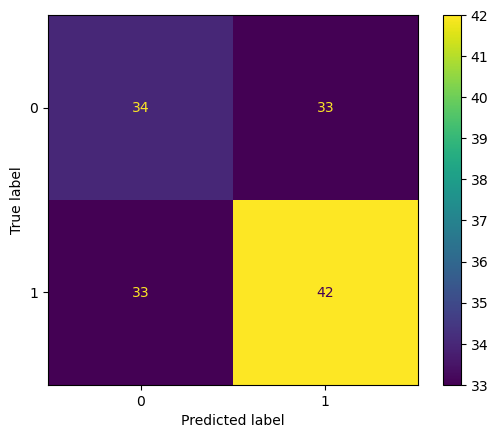

In [33]:
conf_matrix(model_pipeline_pca,X_test)

* Recall appears to be higher than for models B and C, nevertheless, the accuracy score of 53.5% suggests that 1 PC is not sufficient for a significant prediction

***
### Gridsearch
Conduct gridsearch analysis to establish the model accuracy could be improved

In [34]:
c_values = [.00001, .0001, .001, .1, 1, 10, 100, 1000]

logreg_param_grid = [
    
# l1
    {'scaler': [StandardScaler(),MinMaxScaler()],
    'dim_reducer': [PCA()],
    'dim_reducer__n_components': [1,2,4,10,0.8,0.9,0.95,None],
    'model': [LogisticRegression(penalty='l1',solver='saga',random_state=22,n_jobs=-1,max_iter=10000)],
    'model__C': c_values,
    'model__solver': ['saga']},
    
# l2
    {'scaler': [StandardScaler(),MinMaxScaler()],
    'dim_reducer': [PCA()],
    'dim_reducer__n_components': [1,2,4,10,0.8,0.9,0.95,None],
    'model': [LogisticRegression(penalty='l2',random_state=22,n_jobs=-1,max_iter=10000)],
    'model__C': c_values,
    'model__solver': ['lbfgs']}]
    

model_pipeline_pca = Pipeline([
    ('scaler', MinMaxScaler()),
    ('dim_reducer', PCA()),
    ('model', LogisticRegression())   # linear regression model
])


# Instantiate the log reg grid search
logreg_gs = GridSearchCV(
    model_pipeline_pca,
    param_grid=logreg_param_grid,
    cv=5,
    n_jobs=-1,verbose=1,return_train_score=True
    )

`let's first test the model with all features` - **model A**

In [35]:
tuned_logreg_gs = logreg_gs.fit(X_rem, y_rem)

tuned_logreg_gs.best_params_

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


{'dim_reducer': PCA(n_components=2),
 'dim_reducer__n_components': 2,
 'model': LogisticRegression(C=10, max_iter=10000, n_jobs=-1, penalty='l1',
                    random_state=22, solver='saga'),
 'model__C': 10,
 'model__solver': 'saga',
 'scaler': MinMaxScaler()}

In [36]:
tuned_logreg_gs.best_score_

0.5745225896599907

* cross-validation score is significantly lower than the previous test score
* this is likely because running a cross-fold validation made the model more generalized, which is a crucial feature for a real-life model
* random fluctuations may have influenced the previous test score in the test set 
* it's also possible that some data regions within the cross-validation gave particularly low scores, indicating that the model is not performing well on those particular data points or regions

***

* Let's also run gridsearch on the columns filtered by ttest
* recall that test scores differed drastically when using a single test-train split
  * with the model fitted on all features resulting in higher scores

In [37]:
tuned_logreg_gs = logreg_gs.fit(X_rem_ttest, y_rem)

tuned_logreg_gs.best_params_

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


{'dim_reducer': PCA(n_components=2),
 'dim_reducer__n_components': 2,
 'model': LogisticRegression(C=0.0001, max_iter=10000, n_jobs=-1, random_state=22),
 'model__C': 0.0001,
 'model__solver': 'lbfgs',
 'scaler': StandardScaler()}

In [38]:
tuned_logreg_gs.best_score_

0.572783729234591

* While testing model A (all features) and B on a single train-test split results in a big accuracy score difference
* running cross-validation on these two sets of features resulted in the same accuracy scores
  * indicating that the statistical test conducted in notebook 3 was meaningful


* Fitting logistic models above allowed extracting some valuable indicators, such as Masonry Contacts being more frequent in districts that are gentrifying, but ultimately accuracy scores remained low.
* More data would need to be added to improve the scores

***
<center><h3> NLP Model <center><h3>

* Let's run NLP models to see if more information could be extracted

In [116]:
from sklearn.feature_extraction.text import TfidfVectorizer
import string

# import the nltk stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tag import pos_tag 
from nltk.stem import PorterStemmer

STOP_WORDS = stopwords.words('english')
STOP_WORDS.append('per')

def my_tokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listof_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in STOP_WORDS) & (len(word)>2) & (not bool(re.search('\d', word))):
            #stemmer = PorterStemmer()
            #stemmed_word = stemmer.stem(word)
            #listof_words.append(stemmed_word)
            listof_words.append(word)
        else:
            continue

    return listof_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\44742\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [117]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer

class Description_Vector(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.vectorizer = TfidfVectorizer(tokenizer=my_tokenizer,min_df=0.05, max_df=0.8)
        
    def fit(self, df, y=None):
        description=df['WORK_DESCRIPTION']
        self.vectorizer.fit(description)
        return self
        
    def transform(self, df, y=None):
        '''
        This methos vectorizers one columnn but returns the whole dataframe
        '''
        description=df['WORK_DESCRIPTION']
        description_transformed = self.vectorizer.transform(description)
        feature_names=self.vectorizer.get_feature_names_out()
        df_vect=pd.DataFrame(description_transformed.toarray(), columns=feature_names)
        df_return=pd.concat([df.reset_index(drop=True),df_vect.reset_index(drop=True)],axis=1).drop(columns='WORK_DESCRIPTION')
        return df_return
    
    

In [120]:
year=2015
train_period=5
prediction_period=5
metric='power'
perc_power=2

X_y_prep_nlp = Pipeline(
    [
    #grouping based on the year we are making the prediction from and the training length
    ('group',FunctionTransformer(df_window_multi_type, kw_args={'year': year, 't': train_period})),
    #convert income change into y_target based on the year we are making the prediction from and the prediction length and drop the remaining of Income columns
    ('target',GentrificationTarget(year,prediction_period,metric,perc_power)),
    #split into X & y
    ('vector',Description_Vector()),
    ('X_y_split',FunctionTransformer(select_columns))
    ])

In [121]:
#select only Work Description, Year, Census_Tract columns and columns containing Mean
df_rem_nlp=pd.concat([df_rem['WORK_DESCRIPTION'],df_rem['YEAR'],df_rem['Census_Tract'],get_columns_with_regex(df_rem,'Mean')],axis=1)
df_test_nlp=pd.concat([df_test['WORK_DESCRIPTION'],df_test['YEAR'],df_test['Census_Tract'],get_columns_with_regex(df_test,'Mean')],axis=1)

X_y_prep_nlp.fit(df_rem_nlp)
X_rem_nlp,y_rem=X_y_prep_nlp.transform(df_rem_nlp)
X_test_nlp,y_test=X_y_prep_nlp.transform(df_test_nlp)

In [122]:
model_pipeline_nlp = Pipeline([
    ('scaler', MinMaxScaler()),
    ('regressor', LogisticRegression())   # linear regression model
])

model_pipeline_nlp.fit(X_rem_nlp,y_rem)
nlp_model=model_pipeline_nlp

train_accuracy = nlp_model.score(X_rem_nlp, y_rem)
test_accuracy = nlp_model.score(X_test_nlp, y_test)

print(f'Baseline model train accuracy is {train_accuracy*100:.2f}%')
print(f'Baseline model test accuracy is {test_accuracy*100:.2f}%')

Baseline model train accuracy is 100.00%
Baseline model test accuracy is 58.45%


* The first model iteration strongly overfits since train accuracy is significatnly higher than the test accuracy
* Let's reduce c-hyperparameter to reduce overfitting by penalizing large weights in the model.

In [44]:
model_pipeline_nlp = Pipeline([
    ('scaler', MinMaxScaler()),
    ('regressor', LogisticRegression(C=0.005))   # reduce c-value to reduce overfitting
])

model_pipeline_nlp.fit(X_rem_nlp,y_rem)
nlp_model=model_pipeline_nlp

train_accuracy = nlp_model.score(X_rem_nlp, y_rem)
test_accuracy = nlp_model.score(X_test_nlp, y_test)

print(f'Baseline model train accuracy is {train_accuracy*100:.2f}%')
print(f'Baseline model test accuracy is {test_accuracy*100:.2f}%')

Baseline model train accuracy is 76.80%
Baseline model test accuracy is 61.27%


In [45]:
result_coeff=pd.DataFrame({'feature':list(X_rem_nlp.columns),'coefficient':nlp_model.steps[-1][1].coef_[0]})

In [46]:
#Sort by the largest coefficients
top_20=result_coeff.sort_values('coefficient',ascending=False)[:21].reset_index(drop=True)
bottom_20=result_coeff.sort_values('coefficient')[:21].reset_index(drop=True)

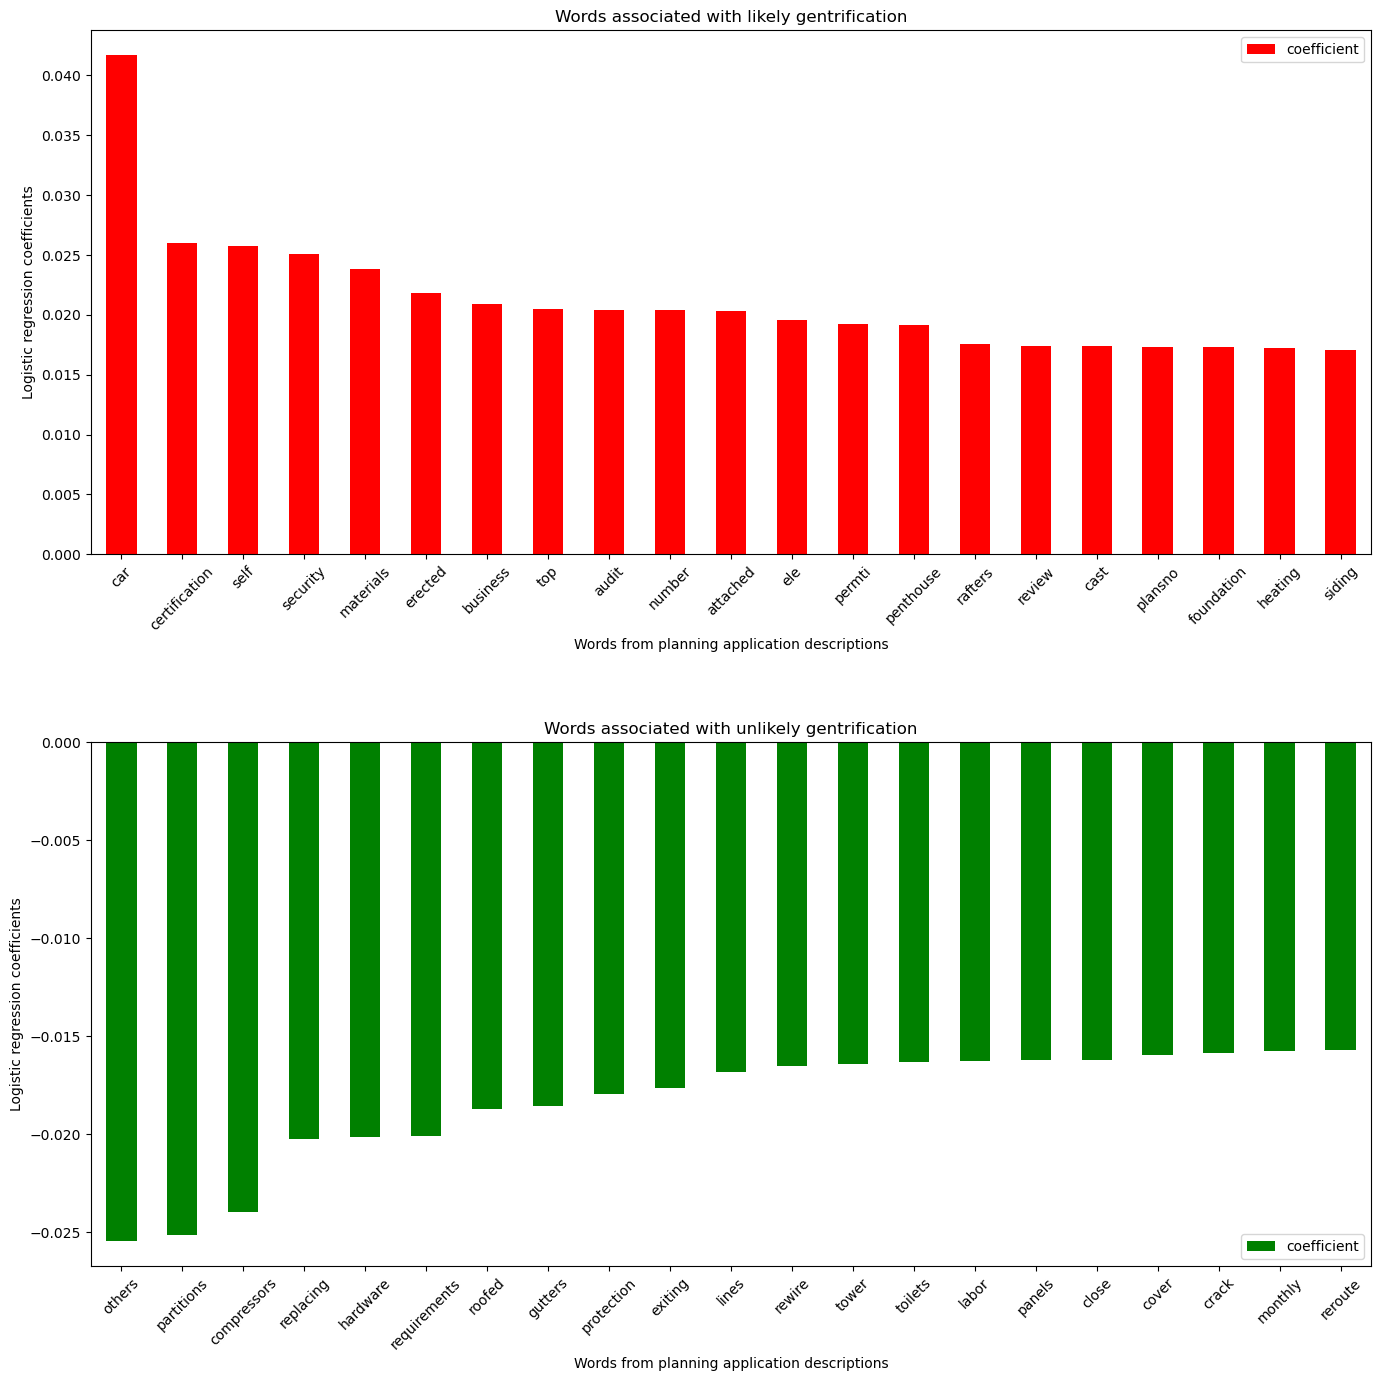

In [47]:
#Plot
fig, axs = plt.subplots(2, 1, figsize=(15, 15))

top_20.set_index('feature').plot(kind="bar", rot=45, ax=axs[0], color="red")
axs[0].set_title("Words associated with likely gentrification")
axs[0].set_xlabel("Words from planning application descriptions")
axs[0].set_ylabel("Logistic regression coefficients")

bottom_20.set_index('feature').plot(kind="bar", rot=45, ax=axs[1], color="green")
axs[1].set_title("Words associated with unlikely gentrification")
axs[1].set_xlabel("Words from planning application descriptions")
axs[1].set_ylabel("Logistic regression coefficients")

fig.tight_layout(pad=5.0)

* Some insightful words to indicate an area gentrifying are 'penthouse' - an indicator of new high-end construction,'car'- an indicator of increased economic activity
* While 'partitions' and 'rewire' are related may be related to renovations and maintenance and,hence, to lower chances of gentrification

* The model can be also used to extract coefficients of specific words

In [123]:
result_coeff[result_coeff['feature']=='cafe']

,feature,coefficient
191,cafe,0.000071


* For example the word, cafe appears to have a small positive coefficient

In [124]:
result_coeff[result_coeff['feature']=='office']

,feature,coefficient
1104,office,0.017065


* A word office has a stronger positive coefficient, suggesting it is a better predictor of gentrification based on the current model


* Let's run a gridsearch to optimise parameters

In [50]:
c_values = [.00001, .0001, .001, .1, 1, 10, 100, 1000]

logreg_param_grid = [
    
# l1
    {'scaler': [MinMaxScaler()],
    'dim_reducer': [PCA()],
    'dim_reducer__n_components': [0.2,0.4,0.6,0.8,0.9,0.95,None],
    'model': [LogisticRegression(penalty='l1',solver='saga',random_state=22,n_jobs=-1,max_iter=10000)],
    'model__C': c_values,
    'model__solver': ['saga']},
    
# l2
    {'scaler': [MinMaxScaler()],
    'dim_reducer': [PCA()],
    'dim_reducer__n_components': [0.2,0.4,0.6,0.8,0.9,0.95,None],
    'model': [LogisticRegression(penalty='l2',random_state=22,n_jobs=-1,max_iter=10000)],
    'model__C': c_values,
    'model__solver': ['lbfgs']}]
    

model_pipeline_nlp_pca = Pipeline([
    ('scaler', MinMaxScaler()),
    ('dim_reducer', PCA()),
    ('model', LogisticRegression())   # linear regression model
])


# Instantiate the log reg grid search
logreg_gs = GridSearchCV(
    model_pipeline_nlp_pca,
    param_grid=logreg_param_grid,
    cv=5,
    n_jobs=-1,verbose=1,return_train_score=True
    )

tuned_nlp_gs = logreg_gs.fit(X_rem_nlp, y_rem)
tuned_nlp_gs.score(X_test_nlp,y_test)

Fitting 5 folds for each of 112 candidates, totalling 560 fits


0.5985915492957746

* Model accuracy, given that it is a 50/50 classification problem, remains low
* Running grid searches does not appear to improve the test scores drastically
* Apart from other possible reasons, this can also arise from the limited nature of the target variable
  * To improve scores, better data for the target variable would need to be obtained
  * Ultimately, relying exclusively on income data is not sufficient to evaluate gentrification
* Nevertheless, it should also be noted that so far we have been running grid-searched on relatively small datasets
  * consider increasing the size of the dataset by constructing stacked dataframes
  * for exmaple, instead of predicting gentrification from 2015 to 2020 for each area,
  * predict for each 5 year ranges in-between 2015 and 2020

---
<center><h3>Model Interation: Stacked Model <center><h3>

This subsection will 
* Create Baseline Stacked Model
* Looping through different combinations of train and prediciton windows to establish optimal timeframes
* Gridsearch for stacked model

* Next steps: add a way to concat data given specific train and prediction periods

In [51]:
#define a custom column transformer to stack the dataset as a part of pre-processing

class GentrificationTarget_Stacked(BaseEstimator, TransformerMixin):
    def __init__(self,training_period,prediction_period):
        self.training_period=training_period
        self.prediction_period=prediction_period
        self.median_change=None

        #the last year we can make the prediction from = 2021 (last year in the income dataset) - prediction windows
        self.year_last_from=2021-self.prediction_period
        #range of years we can predict from. +1 to be inclusive of the last year
        self.year_from_range=range(2010,self.year_last_from+1)

    def fit(self,df,y=None):

        median_di={}

        for year_from in self.year_from_range:
            #only need Median and YEAR columns
            mask=[col for col in list(df.columns) if bool(re.search('Mean',col)) or col in ['Census_Tract','YEAR']]
            df_temp=df_window_multi_type(df[mask],year_from,self.training_period)

            #name of the column containing income for the current year
            current_income_col='Mean_Income_'+str(year_from)
            #the year we are making the prediction for
            prediction_year=year_from+self.prediction_period

            #name of the column containing income for the year we are making the prediction for
            future_income_col='Mean_Income_'+str(prediction_year)

            current_income=df_temp[current_income_col]
            future_income=df_temp[future_income_col]

            combined_change=[comb_change_calc(start,finish) for (start,finish) in zip(current_income,future_income)]

            #for each year create a key:value dictionary pair
            median_di[year_from]=np.median(combined_change)

        #fitting in our case is just finding the mean change
        self.median_changes=median_di
        #returning self with updated attributes that can be accessed in the transform method later
        return self

    def transform(self, df, y=None):
        #this method transforms the existing dataframe to calculate if the change for each geography was more or less than the mean & dropping all the other columns

        #instantiate an empty df for X features
        df_result=pd.DataFrame() 


        #loop for all years less or equal to the last year we can predict from
        for year_from in self.year_from_range:

            #for each loop filter by year, average numeric columns & add concat strings for each year
            df_temp=df_window_multi_type(df,year_from,self.training_period)

            #for each loop determine the year we are predicting for
            prediction_year=year_from+self.prediction_period

            #get income for the year the prediction is made FROM
            current_income_col='Mean_Income_'+str(year_from)
            current_income=df_temp[current_income_col]

            #get income for the year the prediction is made FOR
            future_income=df_temp['Mean_Income_'+str(prediction_year)]

            #calculate change
            combined_change=[comb_change_calc(start,finish) for (start,finish) in zip(current_income,future_income)]
            
            median_temp=self.median_changes[year_from]
            target_temp=[1 if i>median_temp else 0 for i in combined_change]

            #drop all Income columns
            y_col=[col for col in list(df_temp.columns) if bool(re.search('Mean',col))]
            df_temp=df_temp.drop(columns=y_col)

            #add current income column back but rename as Income (otherwise for each loop the name would be different)
            df_temp['Income']=current_income

            #add target column
            df_temp['Target']=target_temp

            #keep concating df_temp to df_result for each loop 
            df_result=pd.concat([df_result,df_temp])

        #separate into X and y
        X = df_result.drop(columns='Target')
        y = df_result['Target']

        return X,y

In [52]:
#define a function to drop columns that did not pass the statistical test
def col_drop(df):
    #ensure the input is 
    df_temp=pd.DataFrame(df)
    new_df=df_temp.drop(columns=columns_to_drop)
    return new_df

In [53]:
cachedir = mkdtemp()

train_period=5
prediction_period=5

X_y_prep_stacked = Pipeline(
    [
    #one hot encoding
    ('ohe', CustomOneHotEncoder_CT()),
    #drop columns that did not pass statistical test,
    ('col_drop',FunctionTransformer(col_drop)),
    #convert income change into y_target based on the year we are making the prediction from and the prediction length and drop the remaining of Income columns
    ('target',GentrificationTarget_Stacked(train_period,prediction_period))
    ],
    memory=cachedir)

In [54]:
model_pipeline_stacked = Pipeline([
    ('scaler', MinMaxScaler()),   # data normalization step
    ('model', LogisticRegression(max_iter=1000))   # linear regression model
])

In [55]:
X_y_prep_stacked.fit(df_rem)
X_rem,y_rem=X_y_prep_stacked.transform(df_rem)
X_test,y_test=X_y_prep_stacked.transform(df_test)

X_rem=X_rem.drop(columns='WORK_DESCRIPTION')
X_test=X_test.drop(columns='WORK_DESCRIPTION')

model_pipeline_stacked.fit(X_rem,y_rem)
accuracy = model_pipeline_stacked.score(X_test, y_test)

In [56]:
print(f'Stacked model accuracy is {accuracy*100:.2f}%')

Stacked model accuracy is 56.22%


In [57]:
model_pipeline_stacked.score(X_rem,y_rem)

0.5936642554252931

* Run through all possible combinations of train_period & prediction_period to determine optimal prediction and train windows

`20+ min to run`

In [58]:
'''#loop through each combination of train_period & prediction_period and store test accuracy

#train_period should not exceed 5 years because then predictions from 2010 would not be accurate

import itertools

train_range = [i+1 for i in range(5)]
prediction_range = [i+1 for i in range(11)]

df_results=pd.DataFrame({'train_range':[],'prediction_range':[],'train_score':[],'test_score':[]})


for i, pair in enumerate(itertools.product(train_range, prediction_range)):

    train_period=pair[0]
    prediction_period=pair[1]

    X_y_prep_stacked = Pipeline(
    [('ohe', CustomOneHotEncoder_CT()),
    ('target',GentrificationTarget_Stacked(train_period,prediction_period))],
    memory=cachedir)

    X_y_prep_stacked.fit(df_rem)
    X_rem,y_rem=X_y_prep_stacked.transform(df_rem)
    X_test,y_test=X_y_prep_stacked.transform(df_test)

    X_rem=X_rem.drop(columns='WORK_DESCRIPTION')
    X_test=X_test.drop(columns='WORK_DESCRIPTION')

    model_pipeline_stacked.fit(X_rem,y_rem)

    train_accuracy=model_pipeline_stacked.score(X_rem, y_rem)
    test_accuracy = model_pipeline_stacked.score(X_test, y_test)

    df_results.loc[i] = [train_period, prediction_period, train_accuracy, test_accuracy]'''


"#loop through each combination of train_period & prediction_period and store test accuracy\n\n#train_period should not exceed 5 years because then predictions from 2010 would not be accurate\n\nimport itertools\n\ntrain_range = [i+1 for i in range(5)]\nprediction_range = [i+1 for i in range(11)]\n\ndf_results=pd.DataFrame({'train_range':[],'prediction_range':[],'train_score':[],'test_score':[]})\n\n\nfor i, pair in enumerate(itertools.product(train_range, prediction_range)):\n\n    train_period=pair[0]\n    prediction_period=pair[1]\n\n    X_y_prep_stacked = Pipeline(\n    [('ohe', CustomOneHotEncoder_CT()),\n    ('target',GentrificationTarget_Stacked(train_period,prediction_period))],\n    memory=cachedir)\n\n    X_y_prep_stacked.fit(df_rem)\n    X_rem,y_rem=X_y_prep_stacked.transform(df_rem)\n    X_test,y_test=X_y_prep_stacked.transform(df_test)\n\n    X_rem=X_rem.drop(columns='WORK_DESCRIPTION')\n    X_test=X_test.drop(columns='WORK_DESCRIPTION')\n\n    model_pipeline_stacked.fit(X

In [34]:
#joblib.dump(df_results, '../data/interim/window_optimization.pkl')
df_results=joblib.load('../data/interim/window_optimization.pkl')

In [35]:
df_results.sort_values('test_score',ascending=False)[:20]

,train_range,prediction_range,train_score,test_score
16,2.0,6.0,0.598810,0.637786
27,3.0,6.0,0.617052,0.629280
38,4.0,6.0,0.621354,0.624706
43,4.0,11.0,0.648696,0.624113
54,5.0,11.0,0.648696,0.624113
5,1.0,6.0,0.602112,0.620859
53,5.0,10.0,0.666087,0.620567
49,5.0,6.0,0.622965,0.620164
52,5.0,9.0,0.652199,0.619718
51,5.0,8.0,0.644502,0.613357


* The best scores are observed for longer prediction periods, this cna be explained by:
  * 1) Volatility in the target variable
  * 2) Gentrification being a long-term change

* Overall, the scores remain around 60% even when using the stacked dataframe and increasing the number of datapoints.

***

Summary and the main Next Steps:
* The main next step would be to improve the accuracy of the target variable at predicting gentrification by introducing other variables, such as education or crime levels
  * It would also be beneficial to consider adjusting the calssification threshold split and consider introdusing more classes
  * while splitting data using media, might at first seem to be a problem simplification, in reality, might also make it more difficult to split data, since the majority if datapoints would be around the median
* While numerical and vategorical features were explored extensively, Work Description column has potential to be investigated much further
  * running initial topic analysis already offered interesting insights such as that many permits currenly classified as Renovation Permits, in fact, are maintenance-related
  * further topic analysis can be helpful to have more control over the assignment of permit types